In [1]:
## install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
## install finrl library
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

✨🍰✨ Everything looks OK!
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-qk9urer7
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-qk9urer7
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit cfdbe462627bd6355dccee215c1aac65873c6d67
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-nnc3mvzy/elegantrl_48952efbfb7c4b988e940b76d8b43512
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-nnc3mvzy/elegantrl_48952efbfb7c4b988e940b76d8b43512
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 59fe4b4a1cca0a28e8a5fa4fb80eed9b5d472978
  Preparing metadata (setup.py) ... done


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

In [5]:
# cd "/content/drive/MyDrive/finrl"

In [6]:
# !git clone https://github.com/MinkyuRamen/KubigFinancialProject.git

In [7]:
# from google.colab import files
# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [9]:
# %pip install -r requirements.txt --user
# %pip install SQLAlchemy==1.4.46

In [10]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm

%matplotlib inline
ticker = ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [11]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)


TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-04-04' # 앙상블 validation window 가 63일로 1 QUARTER 이라서 기간이 끊김. 앙상블이랑 기간 맞춰주기 위해 앙상블 trading이 끝나는 시점으로 맞춤.

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [12]:
prediction_5 = pd.read_csv('/content/drive/MyDrive/prediction_5.csv').set_index('Unnamed: 0')
prediction_10 = pd.read_csv('/content/drive/MyDrive/prediction_10.csv').set_index('Unnamed: 0')
prediction_30 = pd.read_csv('/content/drive/MyDrive/prediction_30.csv').set_index('Unnamed: 0')

In [13]:
# preprocess
import yfinance as yf

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ticker).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (30015, 8)


In [14]:
fe = FeatureEngineer(
    use_technical_indicator = True,
    tech_indicator_list = INDICATORS,
    use_vix=True,
    use_turbulence=True,
    user_defined_feature=False
)
processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3334, 8)
Successfully added vix
Successfully added turbulence index


In [15]:
processed.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,33.580002,34.020000,33.450001,25.364525,7567500,XLB,0,0.0,25.521517,25.289546,100.0,66.666667,100.0,25.364525,25.364525,20.040001,0.0
1,2010-01-04,57.919998,58.810001,57.790001,37.747688,16928400,XLE,0,0.0,25.521517,25.289546,100.0,66.666667,100.0,37.747688,37.747688,20.040001,0.0
2,2010-01-04,11.795288,11.965881,11.770918,9.344014,92942347,XLF,0,0.0,25.521517,25.289546,100.0,66.666667,100.0,9.344014,9.344014,20.040001,0.0
3,2010-01-04,28.090000,28.320000,27.959999,21.793036,7471500,XLI,0,0.0,25.521517,25.289546,100.0,66.666667,100.0,21.793036,21.793036,20.040001,0.0
4,2010-01-04,23.139999,23.290001,23.100000,19.110195,8449400,XLK,0,0.0,25.521517,25.289546,100.0,66.666667,100.0,19.110195,19.110195,20.040001,0.0


In [16]:
list_ticker = processed["tic"].unique().tolist() #ticker 리스트 불러오기
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str)) #전체 데이터 날짜 날짜 리스트
combination = list(itertools.product(list_date,list_ticker)) #date, ticker 의 combination

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left") #date, tic combination 기준으로 우측에 해당되는 정보들 정리
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)
processed_full

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,XLB,33.580002,34.020000,33.450001,25.364525,7567500.0,0.0,0.000000,25.521517,25.289546,100.000000,66.666667,100.000000,25.364525,25.364525,20.040001,0.000000
1,2010-01-04,XLE,57.919998,58.810001,57.790001,37.747688,16928400.0,0.0,0.000000,25.521517,25.289546,100.000000,66.666667,100.000000,37.747688,37.747688,20.040001,0.000000
2,2010-01-04,XLF,11.795288,11.965881,11.770918,9.344014,92942347.0,0.0,0.000000,25.521517,25.289546,100.000000,66.666667,100.000000,9.344014,9.344014,20.040001,0.000000
3,2010-01-04,XLI,28.090000,28.320000,27.959999,21.793036,7471500.0,0.0,0.000000,25.521517,25.289546,100.000000,66.666667,100.000000,21.793036,21.793036,20.040001,0.000000
4,2010-01-04,XLK,23.139999,23.290001,23.100000,19.110195,8449400.0,0.0,0.000000,25.521517,25.289546,100.000000,66.666667,100.000000,19.110195,19.110195,20.040001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43510,2023-03-31,XLK,148.699997,151.149994,148.509995,150.694351,7534900.0,4.0,2.791015,150.620449,134.088472,62.741400,174.917639,45.206603,140.488648,137.564060,18.700001,3.638676
43511,2023-03-31,XLP,74.489998,74.739998,74.360001,74.183716,10338700.0,4.0,0.431191,74.030857,69.818979,57.170167,210.842122,24.337658,71.912600,72.301987,18.700001,3.638676
43512,2023-03-31,XLU,67.419998,67.720001,67.029999,67.149887,11722000.0,4.0,0.076162,67.498002,63.093715,52.067330,114.230037,3.428190,65.270845,66.727078,18.700001,3.638676
43513,2023-03-31,XLV,128.520004,129.529999,128.449997,128.929276,9202500.0,4.0,-0.232832,128.920528,123.180957,50.536425,88.117088,0.797991,126.690173,129.505626,18.700001,3.638676


In [17]:
processed_full.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,XLB,33.580002,34.020000,33.450001,25.364525,7567500.0,0.0,0.0,25.521517,25.289546,100.0,66.666667,100.0,25.364525,25.364525,20.040001,0.0
1,2010-01-04,XLE,57.919998,58.810001,57.790001,37.747688,16928400.0,0.0,0.0,25.521517,25.289546,100.0,66.666667,100.0,37.747688,37.747688,20.040001,0.0
2,2010-01-04,XLF,11.795288,11.965881,11.770918,9.344014,92942347.0,0.0,0.0,25.521517,25.289546,100.0,66.666667,100.0,9.344014,9.344014,20.040001,0.0
3,2010-01-04,XLI,28.090000,28.320000,27.959999,21.793036,7471500.0,0.0,0.0,25.521517,25.289546,100.0,66.666667,100.0,21.793036,21.793036,20.040001,0.0
4,2010-01-04,XLK,23.139999,23.290001,23.100000,19.110195,8449400.0,0.0,0.0,25.521517,25.289546,100.0,66.666667,100.0,19.110195,19.110195,20.040001,0.0


In [18]:
prediction_5_list = []
for i in range(len(prediction_5)):
    for j in range(len(ticker)):
        prediction_5_list.append(prediction_5.iloc[i,j])

for i in range((len(processed_full)-len(prediction_5_list))//len(ticker)):
    for j in range(len(ticker)):
        prediction_5_list.append(prediction_5.iloc[-1,j])

prediction_10_list = []
for i in range(len(prediction_10)):
    for j in range(len(ticker)):
        prediction_10_list.append(prediction_10.iloc[i,j])

for i in range((len(processed_full)-len(prediction_10_list))//len(ticker)):
    for j in range(len(ticker)):
        prediction_10_list.append(prediction_10.iloc[-1,j])

prediction_30_list = []
for i in range(len(prediction_30)):
    for j in range(len(ticker)):
        prediction_30_list.append(prediction_30.iloc[i,j])
for i in range((len(processed_full)-len(prediction_30_list))//len(ticker)):
    for j in range(len(ticker)):
        prediction_30_list.append(prediction_30.iloc[-1,j])

print(len(prediction_5_list))

30006


In [19]:
processed_full['prediction_5']=prediction_5_list
processed_full['prediction_10']=prediction_10_list
processed_full['prediction_30']=prediction_30_list

processed_full

,date,tic,open,high,low,close,volume,day,macd,boll_ub,...,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,prediction_5,prediction_10,prediction_30
0,2010-01-04,XLB,33.580002,34.020000,33.450001,25.364525,7567500.0,0.0,0.000000,25.521517,...,100.000000,66.666667,100.000000,25.364525,25.364525,20.040001,0.000000,25.001299,25.008287,28.824316
1,2010-01-04,XLE,57.919998,58.810001,57.790001,37.747688,16928400.0,0.0,0.000000,25.521517,...,100.000000,66.666667,100.000000,37.747688,37.747688,20.040001,0.000000,43.503914,40.740055,41.319206
2,2010-01-04,XLF,11.795288,11.965881,11.770918,9.344014,92942347.0,0.0,0.000000,25.521517,...,100.000000,66.666667,100.000000,9.344014,9.344014,20.040001,0.000000,9.368776,8.849185,10.953069
3,2010-01-04,XLI,28.090000,28.320000,27.959999,21.793036,7471500.0,0.0,0.000000,25.521517,...,100.000000,66.666667,100.000000,21.793036,21.793036,20.040001,0.000000,25.687847,26.830729,29.474950
4,2010-01-04,XLK,23.139999,23.290001,23.100000,19.110195,8449400.0,0.0,0.000000,25.521517,...,100.000000,66.666667,100.000000,19.110195,19.110195,20.040001,0.000000,23.967155,25.295761,25.559303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43510,2023-03-31,XLK,148.699997,151.149994,148.509995,150.694351,7534900.0,4.0,2.791015,150.620449,...,62.741400,174.917639,45.206603,140.488648,137.564060,18.700001,3.638676,159.765030,199.236300,229.869460
43511,2023-03-31,XLP,74.489998,74.739998,74.360001,74.183716,10338700.0,4.0,0.431191,74.030857,...,57.170167,210.842122,24.337658,71.912600,72.301987,18.700001,3.638676,77.748860,81.883970,84.795660
43512,2023-03-31,XLU,67.419998,67.720001,67.029999,67.149887,11722000.0,4.0,0.076162,67.498002,...,52.067330,114.230037,3.428190,65.270845,66.727078,18.700001,3.638676,72.211586,72.498500,82.259070
43513,2023-03-31,XLV,128.520004,129.529999,128.449997,128.929276,9202500.0,4.0,-0.232832,128.920528,...,50.536425,88.117088,0.797991,126.690173,129.505626,18.700001,3.638676,131.804820,142.887970,185.065430


In [20]:
processed_full.to_csv('processed_full.csv')

In [21]:
INDICATORS += ['prediction_5','prediction_10','prediction_30']

In [22]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

26613
3393


In [23]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

# Env

In [24]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension #현재 상태를 나타내는 state를 정의. 1+ ticker 개수 x2 + 인디케이터 개수 x ticker개수
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 9, State Space: 118


In [25]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension


env_kwargs_uni = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}
# env_kwargs_multi = {
#     "hmax": 100,
#     "initial_amount": 1000000,
#     "buy_cost_pct": 0.001,
#     "sell_cost_pct": 0.001,
#     "state_space": state_space,
#     "stock_dim": stock_dimension,
#     "tech_indicator_list": INDICATORS,
#     "action_space": stock_dimension,
#     "reward_scaling": 1e-4,
#     "print_verbosity":5

# }


e_train_gym = StockTradingEnv(df = train, **env_kwargs_uni) # 전체 데이터셋에 대한 것이므로 앙상블 진행시 배제

## kwargs setting

In [26]:
# A2C_model_kwargs = {
#                     'n_steps': 5, # batch_size = n_steps * n_env
#                     'ent_coef': 0.005,
#                     'learning_rate': 0.0007,
#                     # 'gae_lambda': 0.5,
#                     'device':'cuda'
#                     }

# PPO_model_kwargs = {
#                     'ent_coef': 0.0005,
#                     "n_steps": 2048,
#                     'learning_rate': 0.05,
#                     'batch_size': 256,
#                     # 'gae_lambda': 0.5,
#                     'device':'cuda'
#                     }

# DDPG_model_kwargs = {
#                       "action_noise":"ornstein_uhlenbeck",
#                       "buffer_size": 1_000_000,
#                       "learning_rate": 0.0005,
#                       "batch_size": 64,
#                       'device':'cuda'
#                     }

# TD3_model_kwargs = {
#                       "action_noise":"ornstein_uhlenbeck",
#                       "buffer_size": 1_000_000,
#                       "learning_rate": 0.0005,
#                       "batch_size": 64,
#                       'device':'cuda'
#                     }
# SAC_model_kwargs = {
#                       "action_noise":"ornstein_uhlenbeck",
#                       "buffer_size": 1_000_000,
#                       "learning_rate": 0.0005,
#                       "batch_size": 64,
#                       'device':'cuda'
#                     }

# timesteps_dict = {'a2c' : 100_000, # total number of samples (env steps) to train on
#                  'ppo' : 100_000,
#                  'ddpg' : 80_000,
#                  'td3' : 100_000,
#                  'sac' : 100_000
#                  }

# Env

In [28]:
import inspect
source_code = inspect.getsource(StockTradingEnv)
# paste class `StockTradingEnv` from source code above
print(source_code)

class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df: pd.DataFrame,
        stock_dim: int,
        hmax: int,
        initial_amount: int,
        num_stock_shares: list[int],
        buy_cost_pct: list[float],
        sell_cost_pct: list[float],
        reward_scaling: float,
        state_space: int,
        action_space: int,
        tech_indicator_list: list[str],
        turbulence_threshold=None,
        risk_indicator_col="turbulence",
        make_plots: bool = False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.num_stock_shares = num_stock_shares
        self.initial_amount = initial_amount  # get the initial cash
        self.bu

✅ Check class `StockTradingEnv(gym.Env)` to customize/debug errors

In [30]:
from __future__ import annotations

from typing import List

import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gymnasium import spaces
from gymnasium.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv
matplotlib.use("Agg")

class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df: pd.DataFrame,
        stock_dim: int,
        hmax: int,
        initial_amount: int,
        num_stock_shares: list[int],
        buy_cost_pct: list[float],
        sell_cost_pct: list[float],
        reward_scaling: float,
        state_space: int,
        action_space: int,
        tech_indicator_list: list[str],
        turbulence_threshold=None,
        risk_indicator_col="turbulence",
        make_plots: bool = False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.num_stock_shares = num_stock_shares
        self.initial_amount = initial_amount  # get the initial cash
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        # action space
        # normalize action space with action space dimension
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        # state space
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [
            self.initial_amount
            + np.sum(
                np.array(self.num_stock_shares)
                * np.array(self.state[1 : 1 + self.stock_dim])
            )
        ]  # the initial total asset is calculated by cash + sum (num_share_stock_i * price_stock_i)
        self.rewards_memory = []
        self.actions_memory = []
        self.state_memory = (
            []
        )  # we need sometimes to preserve the state in the middle of trading process
        self.date_memory = [self._get_date()]
        #         self.logger = Logger('results',[CSVOutputFormat])
        # self.reset()
        self._seed()

    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if (
                self.state[index + 2 * self.stock_dim + 1] != True
            ):  # check if the stock is able to sell, for simlicity we just add it in techical index
                # if self.state[index + 1] > 0: # if we use price<0 to denote a stock is unable to trade in that day, the total asset calculation may be wrong for the price is unreasonable
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index + self.stock_dim + 1] > 0:
                    # Sell only if current asset is > 0
                    sell_num_shares = min(
                        abs(action), self.state[index + self.stock_dim + 1]
                    )
                    sell_amount = (
                        self.state[index + 1]
                        * sell_num_shares
                        * (1 - self.sell_cost_pct[index])
                    )
                    # update balance
                    self.state[0] += sell_amount

                    self.state[index + self.stock_dim + 1] -= sell_num_shares
                    self.cost += (
                        self.state[index + 1]
                        * sell_num_shares
                        * self.sell_cost_pct[index]
                    )
                    self.trades += 1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0

            return sell_num_shares

        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence >= self.turbulence_threshold:
                if self.state[index + 1] > 0:
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions
                    if self.state[index + self.stock_dim + 1] > 0:
                        # Sell only if current asset is > 0
                        sell_num_shares = self.state[index + self.stock_dim + 1]
                        sell_amount = (
                            self.state[index + 1]
                            * sell_num_shares
                            * (1 - self.sell_cost_pct[index])
                        )
                        # update balance
                        self.state[0] += sell_amount
                        self.state[index + self.stock_dim + 1] = 0
                        self.cost += (
                            self.state[index + 1]
                            * sell_num_shares
                            * self.sell_cost_pct[index]
                        )
                        self.trades += 1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()

        return sell_num_shares

    def _buy_stock(self, index, action):
        def _do_buy():
            if (
                self.state[index + 2 * self.stock_dim + 1] != True
            ):  # check if the stock is able to buy
                # if self.state[index + 1] >0:
                # Buy only if the price is > 0 (no missing data in this particular date)
                available_amount = self.state[0] // (
                    self.state[index + 1] * (1 + self.buy_cost_pct[index])
                )  # when buying stocks, we should consider the cost of trading when calculating available_amount, or we may be have cash<0
                # print('available_amount:{}'.format(available_amount))

                # update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = (
                    self.state[index + 1]
                    * buy_num_shares
                    * (1 + self.buy_cost_pct[index])
                )
                self.state[0] -= buy_amount

                self.state[index + self.stock_dim + 1] += buy_num_shares

                self.cost += (
                    self.state[index + 1] * buy_num_shares * self.buy_cost_pct[index]
                )
                self.trades += 1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence < self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig(f"results/account_value_trade_{self.episode}.png")
        plt.close()

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        if self.terminal:
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (
                self.state[0]
                + sum(
                    np.array(self.state[1 : (self.stock_dim + 1)])
                    * np.array(
                        self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                    )
                )
                - self.asset_memory[0]
            )  # initial_amount is only cash part of our initial asset
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(
                1
            )
            if df_total_value["daily_return"].std() != 0:
                sharpe = (
                    (252**0.5)
                    * df_total_value["daily_return"].mean()
                    / df_total_value["daily_return"].std()
                )
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(
                    "results/actions_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                df_total_value.to_csv(
                    "results/account_value_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                df_rewards.to_csv(
                    "results/account_rewards_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "results/account_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                plt.close()

            # Add outputs to logger interface
            # logger.record("environment/portfolio_value", end_total_asset)
            # logger.record("environment/total_reward", tot_reward)
            # logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            # logger.record("environment/total_cost", self.cost)
            # logger.record("environment/total_trades", self.trades)

            return self.state, self.reward, self.terminal, False, {}

        else:
            actions = actions * self.hmax  # actions initially is scaled between 0 to 1
            actions = actions.astype(
                int
            )  # convert into integer because we can't by fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)
            begin_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            # print("begin_total_asset:{}".format(begin_total_asset))

            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print(f"Num shares before: {self.state[index+self.stock_dim+1]}")
                # print(f'take sell action before : {actions[index]}')
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
                # print(f'take sell action after : {actions[index]}')
                # print(f"Num shares after: {self.state[index+self.stock_dim+1]}")

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])

            self.actions_memory.append(actions)

            # state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day, :]
            if self.turbulence_threshold is not None:
                if len(self.df.tic.unique()) == 1:
                    self.turbulence = self.data[self.risk_indicator_col]
                elif len(self.df.tic.unique()) > 1:
                    self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state = self._update_state()

            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling
            self.state_memory.append(
                self.state
            )  # add current state in state_recorder for each step

        return self.state, self.reward, self.terminal, False, {}

    def reset(self,seed=None):
        # 이 부분이 원래는 seed 가 arg로 없었는데, DummyVecEnv와 compatible 해야하기 때문에 seed=None 을 arg로 넣었음.
        # initiate state
        self.state = self._initiate_state()

        if self.initial:
            self.asset_memory = [
                self.initial_amount
                + np.sum(
                    np.array(self.num_stock_shares)
                    * np.array(self.state[1 : 1 + self.stock_dim])
                )
            ]
        else:
            previous_total_asset = self.previous_state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(
                    self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                )
            )
            self.asset_memory = [previous_total_asset]

        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        self.episode += 1

        return self.state, {}

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.initial_amount]
                    + self.data.close.values.tolist()
                    + self.num_stock_shares
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )  # append initial stocks_share to initial state, instead of all zero
            else:
                # for single stock
                state = (
                    [self.initial_amount]
                    + [self.data.close]
                    + [0] * self.stock_dim
                    + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
                )
        else:
            # Using Previous State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.previous_state[0]]
                    + self.data.close.values.tolist()
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.previous_state[0]]
                    + [self.data.close]
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
                )
        return state

    def _update_state(self):
        if len(self.df.tic.unique()) > 1:
            # for multiple stock
            state = (
                [self.state[0]]
                + self.data.close.values.tolist()
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(
                    (
                        self.data[tech].values.tolist()
                        for tech in self.tech_indicator_list
                    ),
                    [],
                )
            )

        else:
            # for single stock
            state = (
                [self.state[0]]
                + [self.data.close]
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
            )

        return state

    def _get_date(self):
        if len(self.df.tic.unique()) > 1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    # add save_state_memory to preserve state in the trading process
    def save_state_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            state_list = self.state_memory
            df_states = pd.DataFrame(
                state_list,
                columns=[
                    "cash",
                    "Bitcoin_price",
                    "Gold_price",
                    "Bitcoin_num",
                    "Gold_num",
                    "Bitcoin_Disable",
                    "Gold_Disable",
                ],
            )
            df_states.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            state_list = self.state_memory
            df_states = pd.DataFrame({"date": date_list, "states": state_list})
        # print(df_states)
        return df_states

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda:self])
        obs = e.reset()
        return e, obs


In [31]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension # 1 + 2*주식 개수 + 보조지표*주식개수
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 9, State Space: 118


### Q.

Environment구축을 class `StockTradingEnv` 으로 구현함.

따라서 StockTradingEnv 를 자세하게 들여다 볼 필요가 있음.

또한 State Spaces 가 위와같이 상정되어 있는 이유를 뜯어볼 이유가 있음. `1 + 2*stock_dimension`인 이유가 뭘까?

Action Spaces는 어떻게 구현되어 있는 것인가? (Action Space없이도 RL이 가능한가?)


### A.

`state_space = 1 + 2*stock_dimension`에서 1은 remaining balance에 해당, 2는 각각 stock의 stock price, stock shares에 해당한다. class `StockTradingEnv`내 `def _initiate_state(self):`를 보면 알 수 있다.

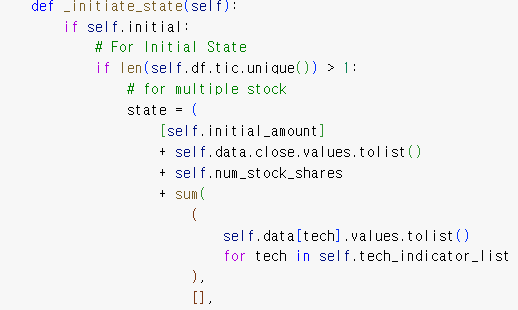

### Q.

그렇다면 해당 Env 에서 Reward Setting이 어떻게 되었을까?



### A.

해당 Env 내부 `tot_reward`를 보면 알 수 있다.

**Reward Setting은 단순하게도, Maximize total balance at time T 이다.**

## Env for Training

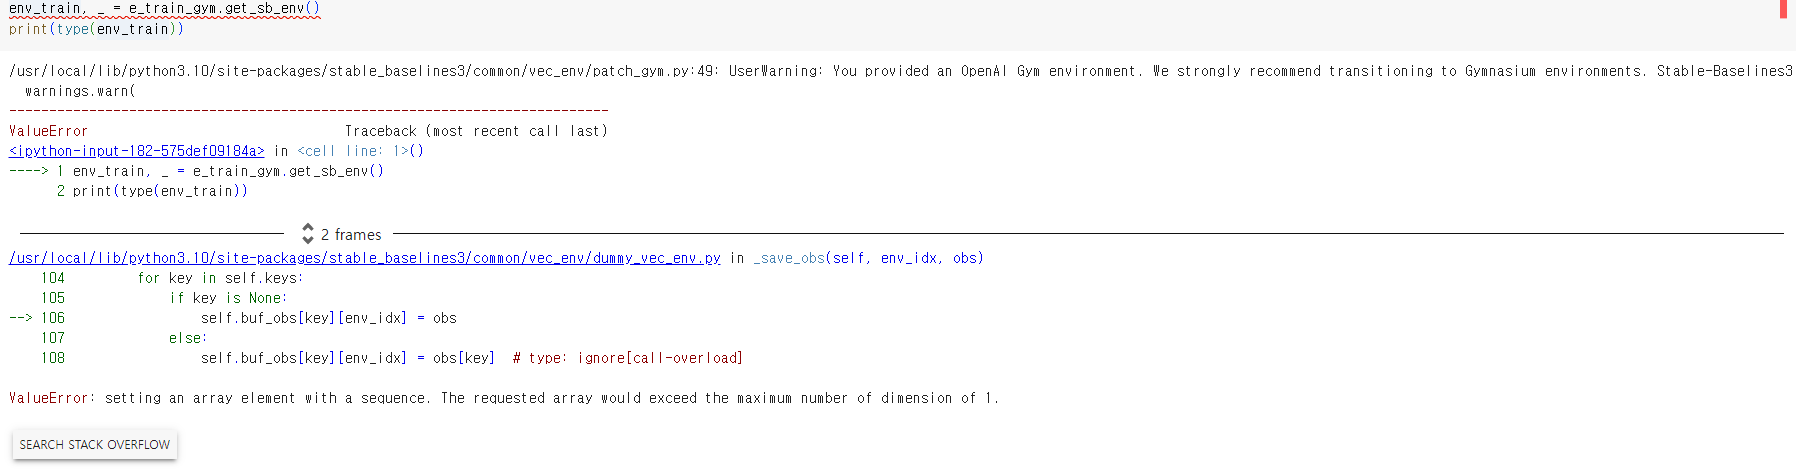

다음과 같은 에러가 뜸.

Open AI gym environment가 아닌 gymnasium으로 바꾸라고 권고함

Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues. 라는 에러가 뜸

따라서 해당 py를 import 해줌.

또한 DummyVecEnv 에러를 보면 길이 1짜리 element가 와야 할 자리에 sequence가 와있어서 에러가 뜬다고 함. 생성된 인스턴스 환경 `e_train_gym`이 어떤 형식으로 오는지는 더 살펴봐야 겠지만 일단은 잘 모르겠어서 위에 조치를 하고 넘어감.

In [32]:
DummyVecEnv([lambda:e_train_gym])

In [33]:
# from collections import OrderedDict
# from typing import Sequence
# from copy import deepcopy

# import numpy as np

# from stable_baselines3.common.vec_env.base_vec_env import VecEnv
# from stable_baselines3.common.vec_env.util import copy_obs_dict, dict_to_obs, obs_space_info


# class DummyVecEnv(VecEnv):
#     """
#     Creates a simple vectorized wrapper for multiple environments, calling each environment in sequence on the current
#     Python process. This is useful for computationally simple environment such as ``cartpole-v1``, as the overhead of
#     multiprocess or multithread outweighs the environment computation time. This can also be used for RL methods that
#     require a vectorized environment, but that you want a single environments to train with.

#     :param env_fns: ([callable]) A list of functions that will create the environments
#         (each callable returns a `Gym.Env` instance when called).
#     """

#     def __init__(self, env_fns):
#         self.envs = [fn() for fn in env_fns]
#         env = self.envs[0]
#         VecEnv.__init__(self, len(env_fns), env.observation_space, env.action_space)
#         obs_space = env.observation_space
#         self.keys, shapes, dtypes = obs_space_info(obs_space)

#         self.buf_obs = OrderedDict([
#             (k, np.zeros((self.num_envs,) + tuple(shapes[k]), dtype=dtypes[k]))
#             for k in self.keys])
#         self.buf_dones = np.zeros((self.num_envs,), dtype=np.bool)
#         self.buf_rews = np.zeros((self.num_envs,), dtype=np.float32)
#         self.buf_infos = [{} for _ in range(self.num_envs)]
#         self.actions = None
#         self.metadata = env.metadata

#     def step_async(self, actions):
#         self.actions = actions

#     def step_wait(self):
#         for env_idx in range(self.num_envs):
#             obs, self.buf_rews[env_idx], self.buf_dones[env_idx], self.buf_infos[env_idx] =\
#                 self.envs[env_idx].step(self.actions[env_idx])
#             if self.buf_dones[env_idx]:
#                 # save final observation where user can get it, then reset
#                 self.buf_infos[env_idx]['terminal_observation'] = obs
#                 obs = self.envs[env_idx].reset()
#             self._save_obs(env_idx, obs)
#         return (self._obs_from_buf(), np.copy(self.buf_rews), np.copy(self.buf_dones),
#                 deepcopy(self.buf_infos))

#     def seed(self, seed=None):
#         seeds = list()
#         for idx, env in enumerate(self.envs):
#             seeds.append(env.seed(seed + idx))
#         return seeds

#     def reset(self):
#         for env_idx in range(self.num_envs):
#             obs = self.envs[env_idx].reset()
#             self._save_obs(env_idx, obs)
#         return self._obs_from_buf()

#     def close(self):
#         for env in self.envs:
#             env.close()

#     def get_images(self) -> Sequence[np.ndarray]:
#         return [env.render(mode='rgb_array') for env in self.envs]

#     def render(self, mode: str = 'human'):
#         """
#         Gym environment rendering. If there are multiple environments then
#         they are tiled together in one image via `BaseVecEnv.render()`.
#         Otherwise (if `self.num_envs == 1`), we pass the render call directly to the
#         underlying environment.

#         Therefore, some arguments such as `mode` will have values that are valid
#         only when `num_envs == 1`.

#         :param mode: The rendering type.
#         """
#         if self.num_envs == 1:
#             return self.envs[0].render(mode=mode)
#         else:
#             return super().render(mode=mode)

#     def _save_obs(self, env_idx, obs):
#         for key in self.keys:
#             if key is None:
#                 self.buf_obs[key][env_idx] = obs
#             else:
#                 self.buf_obs[key][env_idx] = obs[key]

#     def _obs_from_buf(self):
#         return dict_to_obs(self.observation_space, copy_obs_dict(self.buf_obs))

#     def get_attr(self, attr_name, indices=None):
#         """Return attribute from vectorized environment (see base class)."""
#         target_envs = self._get_target_envs(indices)
#         return [getattr(env_i, attr_name) for env_i in target_envs]

#     def set_attr(self, attr_name, value, indices=None):
#         """Set attribute inside vectorized environments (see base class)."""
#         target_envs = self._get_target_envs(indices)
#         for env_i in target_envs:
#             setattr(env_i, attr_name, value)

#     def env_method(self, method_name, *method_args, indices=None, **method_kwargs):
#         """Call instance methods of vectorized environments."""
#         target_envs = self._get_target_envs(indices)
#         return [getattr(env_i, method_name)(*method_args, **method_kwargs) for env_i in target_envs]

#     def _get_target_envs(self, indices):
#         indices = self._get_indices(indices)
#         return [self.envs[i] for i in indices]

In [34]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


### Issues

got error in line `obs, self.reset_infos[env_idx] = self.envs[env_idx].reset(seed=self._seeds[env_idx])` at class `DummyVecEnv` ,

and got **"TypeError: StockTradingEnv.reset() got an unexpected keyword argument 'seed' " .**

Debug it and revise the code

\

\

A.

class `StockTradingEnv(gym.Env):` - `def reset(self)` 에서 argument를 `self` 에서 `reset(self, seed=None)`으로 바꿔줌.

생각보다 간단했음. 단순히 seed arg를 추가해주면 됐음.

어디선가 reset의 arg로 seed를 사용하고 있었다는 얘기. 그게 DummyVecEnv의 reest 에서의 seed임

\

Tip.

앞으로 error messeage 뜨면 복잡하게 생각하지 말고, 해당하는 error가 본질이니 그것에 대해 생각할 것. 복잡하게 생각하는 경향이 있는데 생각보다 단순한 문제일 수 있다.



## Ornstine_Uhlenbeck_Process Estimand

In [35]:
%pip install git+https://github.com/mghadam/ouparams.git

  Cloning https://github.com/mghadam/ouparams.git to /tmp/pip-req-build-0v9zc_xx
  Running command git clone --filter=blob:none --quiet https://github.com/mghadam/ouparams.git /tmp/pip-req-build-0v9zc_xx
  Resolved https://github.com/mghadam/ouparams.git to commit 0862e77b606d833d1955fc47c689661ad12a446d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ouparams: filename=ouparams-0.0.1-py3-none-any.whl size=3344 sha256=31097fb8d451a23c27f0643b8710912ebe529240e64b1b8225b5eba122d3094b
  Stored in directory: /tmp/pip-ephem-wheel-cache-hbhpv0x8/wheels/2a/c9/1d/3d8c7df0a1aa47fcc8488bd8b3625871c16dbea6ff684a2e78
Successfully built ouparams


In [36]:
# preprocess to numpy array

train_close = train.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
train_close
XLB= train_close[train_close['tic']=='XLB']['close'].values
XLE= train_close[train_close['tic']=='XLE']['close'].values
XLF= train_close[train_close['tic']=='XLF']['close'].values
XLI= train_close[train_close['tic']=='XLI']['close'].values
XLK= train_close[train_close['tic']=='XLK']['close'].values
XLP= train_close[train_close['tic']=='XLP']['close'].values
XLU= train_close[train_close['tic']=='XLU']['close'].values
XLV= train_close[train_close['tic']=='XLV']['close'].values
XLY= train_close[train_close['tic']=='XLY']['close'].values

In [37]:
from ouparams import ouparams
sigma_XLB, theta_XLB = ouparams.find(XLB)[1:]
sigma_XLE, theta_XLE = ouparams.find(XLE)[1:]
sigma_XLF, theta_XLF = ouparams.find(XLF)[1:]
sigma_XLI, theta_XLI = ouparams.find(XLF)[1:]
sigma_XLK, theta_XLK = ouparams.find(XLK)[1:]
sigma_XLP, theta_XLP = ouparams.find(XLP)[1:]
sigma_XLU, theta_XLU = ouparams.find(XLU)[1:]
sigma_XLV, theta_XLV = ouparams.find(XLV)[1:]
sigma_XLY, theta_XLY = ouparams.find(XLY)[1:]

print(sigma_XLB, theta_XLB)

0.5638992359146473 0.00010636951135517267


In [38]:
sigma_ = [sigma_XLB, sigma_XLE, sigma_XLF, sigma_XLI ,sigma_XLK, sigma_XLP ,sigma_XLU ,sigma_XLV, sigma_XLY]
theta_ = [theta_XLB, theta_XLE, theta_XLF, theta_XLI ,theta_XLK, theta_XLP ,theta_XLU ,theta_XLV, theta_XLY]

## Agent (Train DRL Agent)

Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)

In [39]:
# DRLAGent() # How action space is defined
# DRL models from Stable Baselines 3
from __future__ import annotations

import time

from stable_baselines3 import A2C
from stable_baselines3 import DDPG
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3 import TD3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv

from finrl import config
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.preprocessor.preprocessors import data_split

MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}

MODEL_KWARGS = {x: config.__dict__[f"{x.upper()}_PARAMS"] for x in MODELS.keys()}

NOISE = {
    "normal": NormalActionNoise,
    "ornstein_uhlenbeck": OrnsteinUhlenbeckActionNoise,
}


class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        try:
            self.logger.record(key="train/reward", value=self.locals["rewards"][0])
        except BaseException:
            self.logger.record(key="train/reward", value=self.locals["reward"][0])
        return True

class DRLAgent:
    """Provides implementations for DRL algorithms

    Attributes
    ----------
        env: gym environment class
            user-defined class

    Methods
    -------
        get_model()
            setup DRL algorithms
        train_model()
            train DRL algorithms in a train dataset
            and output the trained model
        DRL_prediction()
            make a prediction in a test dataset and get results
    """

    def __init__(self, env):
        self.env = env

    def get_model(
        self,
        model_name,
        policy="MlpPolicy",
        policy_kwargs=None,
        model_kwargs=None,
        verbose=1,
        seed=None,
        tensorboard_log=None,
    ):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")

        if model_kwargs is None:
            model_kwargs = MODEL_KWARGS[model_name]

        if "action_noise" in model_kwargs:
            n_actions = self.env.action_space.shape[-1]
            model_kwargs["action_noise"] = NOISE[model_kwargs["action_noise"]](
                mean=np.zeros(n_actions), sigma= sigma_ * np.ones(n_actions), theta=theta_ * np.ones(n_actions)
            )
        print(model_kwargs)
        return MODELS[model_name](
            policy=policy,
            env=self.env,
            tensorboard_log=tensorboard_log,
            verbose=verbose,
            policy_kwargs=policy_kwargs,
            seed=seed,
            **model_kwargs,
        )

    def train_model(self, model, tb_log_name, total_timesteps=5000):
        model = model.learn(
            total_timesteps=total_timesteps,
            tb_log_name=tb_log_name,
            callback=TensorboardCallback(),
        )
        return model

    @staticmethod
    def DRL_prediction(model, environment, deterministic=True):
        test_env, test_obs = environment.get_sb_env()
        """make a prediction"""
        account_memory = []
        actions_memory = []
        #         state_memory=[] #add memory pool to store states
        test_env.reset()
        for i in range(len(environment.df.index.unique())):
            action, _states = model.predict(test_obs, deterministic=deterministic)
            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
            test_obs, rewards, dones, info = test_env.step(action)
            if i == (len(environment.df.index.unique()) - 2):
                account_memory = test_env.env_method(method_name="save_asset_memory")
                actions_memory = test_env.env_method(method_name="save_action_memory")
            #                 state_memory=test_env.env_method(method_name="save_state_memory") # add current state to state memory
            if dones[0]:
                print("hit end!")
                break
        return account_memory[0], actions_memory[0]

    @staticmethod
    def DRL_prediction_load_from_file(model_name, environment, cwd, deterministic=True):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")
        try:
            # load agent
            model = MODELS[model_name].load(cwd)
            print("Successfully load model", cwd)
        except BaseException:
            raise ValueError("Fail to load agent!")

        # test on the testing env
        state = environment.reset()
        episode_returns = []  # the cumulative_return / initial_account
        episode_total_assets = [environment.initial_total_asset]
        done = False
        while not done:
            action = model.predict(state, deterministic=deterministic)[0]
            state, reward, done, _ = environment.step(action)

            total_asset = (
                environment.amount
                + (environment.price_ary[environment.day] * environment.stocks).sum()
            )
            episode_total_assets.append(total_asset)
            episode_return = total_asset / environment.initial_total_asset
            episode_returns.append(episode_return)

        print("episode_return", episode_return)
        print("Test Finished!")
        return episode_total_assets


In [40]:
# algorithm from stable baselines 3
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

## Agent 1: A2C

In [41]:
agent_a2c = DRLAgent(env = env_train)
model_a2c = agent_a2c.get_model("a2c", policy="MlpPolicy", model_kwargs={'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007, 'device': 'cuda'})

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout","csv","tensorboard"])
  # set new logger
  model_a2c.set_logger(new_logger_a2c)

# lr, steps, ent_coef instantiated

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007, 'device': 'cuda'}
Using cuda device
Logging to results/a2c


### Logger

Python에서 logger는 로깅(로그 기록)을 위한 모듈입니다. 로깅은 프로그램이 실행될 때 발생하는 이벤트, 오류, 경고 등의 정보를 기록하는 작업을 말합니다. 이를 통해 프로그램의 동작을 추적하고 디버깅에 도움을 줄 수 있습니다.

\

`new_logger_a2c`는 A2C(A2C - Advantage Actor-Critic) 알고리즘을 사용하는 DRL(Distributed Reinforcement Learning) 에이전트의 로깅을 설정하는 데 사용되는 로거(logger) 객체입니다.

로깅은 주로 프로그램의 실행 과정과 결과를 기록하는 데 사용되며, 디버깅, 성능 모니터링, 실험 기록 등 다양한 목적으로 활용됩니다. 로깅을 통해 알고리즘의 동작, 학습 과정, 보상 등에 대한 정보를 기록하여 분석하고 시각화할 수 있습니다.

위 코드에서 `new_logger_a2c`는 `configure` 함수를 통해 설정된 로깅 방식에 따라 여러 출력 형식으로 로그를 기록할 수 있습니다. stdout(콘솔), csv, tensorboard 등의 **출력 형식**을 지정하여 로그를 기록하도록 설정합니다.

`model_a2c.set_logger(new_logger_a2c)` 코드는 model_a2c에 새로운 로거를 설정하여 A2C 알고리즘의 로깅을 수행합니다. 이를 통해 A2C 알고리즘의 학습 과정과 결과를 지정된 출력 형식으로 기록할 수 있습니다.

In [42]:
trained_a2c = agent_a2c.train_model(model=model_a2c,
                                    tb_log_name = 'a2c',
                                    total_timesteps=100_000) if if_using_a2c else None

--------------------------------------
| time/                 |            |
|    fps                | 150        |
|    iterations         | 100        |
|    time_elapsed       | 3          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -12.8      |
|    explained_variance | -0.702     |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -24.5      |
|    reward             | 0.03738666 |
|    std                | 1.01       |
|    value_loss         | 5.85       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 157       |
|    iterations         | 200       |
|    time_elapsed       | 6         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -12.9     |
|    explained_variance | 0.306     |
|    learning_rate      | 0.0007  

## Agent 2 : DDPG

In [43]:
agent_ddpg = DRLAgent(env = env_train)
model_ddpg = agent_ddpg.get_model("ddpg", policy="MlpPolicy", model_kwargs={
                                  "action_noise":"ornstein_uhlenbeck",
                                  "buffer_size": 1_000_000,
                                  "learning_rate": 0.0005,
                                  "batch_size": 64,
                                  'device':'cuda'})

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma=[0.56389924 0.72619497 0.26787683 0.26787683 0.88537625 0.38545566
 0.47702929 0.72945688 1.02494153]), 'buffer_size': 1000000, 'learning_rate': 0.0005, 'batch_size': 64, 'device': 'cuda'}
Using cuda device
Logging to results/ddpg


In [44]:
trained_ddpg = agent_ddpg.train_model(model=model_ddpg,
                                tb_log_name='ddpg',
                                total_timesteps=80_000) if if_using_ddpg else None

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 124        |
|    time_elapsed    | 94         |
|    total_timesteps | 11828      |
| train/             |            |
|    actor_loss      | -301       |
|    critic_loss     | 790        |
|    learning_rate   | 0.0005     |
|    n_updates       | 8871       |
|    reward          | -6.1020756 |
-----------------------------------
day: 2956, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 3836135.83
total_reward: 2836135.83
total_cost: 2626.36
total_trades: 13833
Sharpe: 0.828
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 114       |
|    time_elapsed    | 206       |
|    total_timesteps | 23656     |
| train/             |           |
|    actor_loss      | -87.1     |
|    critic_loss     | 134       |
|    learning_rate   | 0.0005    |
|    n_updates       |

## Agent 3 : PPO

In [45]:
agent_ppo = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.0005,
    "learning_rate": 0.05,
    "batch_size": 256,
    'device': 'cuda'
}
model_ppo = agent_ppo.get_model("ppo",policy="MlpPolicy",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.0005, 'learning_rate': 0.05, 'batch_size': 256, 'device': 'cuda'}
Using cuda device
Logging to results/ppo


In [46]:
trained_ppo = agent_ppo.train_model(model=model_ppo,
                                    tb_log_name='ppo',
                                    total_timesteps=100_000) if if_using_ppo else None

----------------------------------
| time/              |           |
|    fps             | 224       |
|    iterations      | 1         |
|    time_elapsed    | 9         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.3934772 |
----------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 220        |
|    iterations           | 2          |
|    time_elapsed         | 18         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 22.383862  |
|    clip_fraction        | 0.987      |
|    clip_range           | 0.2        |
|    entropy_loss         | -23.7      |
|    explained_variance   | 0.00454    |
|    learning_rate        | 0.05       |
|    loss                 | 1.34       |
|    n_updates            | 10         |
|    policy_gradient_loss | 0.261      |
|    reward               | 0

## Agent 4 : TD3

In [47]:
agent_td3 = DRLAgent(env = env_train)
TD3_PARAMS = {"action_noise":"ornstein_uhlenbeck",
              "batch_size": 64,
              "buffer_size": 1_000_000,
              "learning_rate": 0.0005,
              "device" : "cuda"}

model_td3 = agent_td3.get_model("td3",policy="MlpPolicy",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma=[0.56389924 0.72619497 0.26787683 0.26787683 0.88537625 0.38545566
 0.47702929 0.72945688 1.02494153]), 'batch_size': 64, 'buffer_size': 1000000, 'learning_rate': 0.0005, 'device': 'cuda'}
Using cuda device
Logging to results/td3


In [48]:
trained_td3 = agent_td3.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=100_000) if if_using_td3 else None

day: 2956, episode: 100
begin_total_asset: 1000000.00
end_total_asset: 2684620.39
total_reward: 1684620.39
total_cost: 2057.35
total_trades: 11621
Sharpe: 0.505
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 130        |
|    time_elapsed    | 90         |
|    total_timesteps | 11828      |
| train/             |            |
|    actor_loss      | 112        |
|    critic_loss     | 1.28e+03   |
|    learning_rate   | 0.0005     |
|    n_updates       | 8871       |
|    reward          | -2.8115647 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 121        |
|    time_elapsed    | 194        |
|    total_timesteps | 23656      |
| train/             |            |
|    actor_loss      | 93.1       |
|    critic_loss     | 43.3       |
|    learning_rate   | 0.0005     |
|    n_upda

## Agent 5 : SAC

In [49]:
agent_sac = DRLAgent(env = env_train)
SAC_PARAMS = {"action_noise":"ornstein_uhlenbeck",
              "buffer_size": 1_000_000,
              "learning_rate": 0.0005,
              "batch_size": 64,
              'device':'cuda'}

model_sac = agent_td3.get_model("sac",policy="MlpPolicy",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma=[0.56389924 0.72619497 0.26787683 0.26787683 0.88537625 0.38545566
 0.47702929 0.72945688 1.02494153]), 'buffer_size': 1000000, 'learning_rate': 0.0005, 'batch_size': 64, 'device': 'cuda'}
Using cuda device
Logging to results/sac


In [50]:
trained_sac = agent_sac.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=100_000) if if_using_sac else None

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 66         |
|    time_elapsed    | 177        |
|    total_timesteps | 11828      |
| train/             |            |
|    actor_loss      | 3.08e+05   |
|    critic_loss     | 9.68e+05   |
|    ent_coef        | 310        |
|    ent_coef_loss   | -482       |
|    learning_rate   | 0.0005     |
|    n_updates       | 11727      |
|    reward          | -6.1826296 |
-----------------------------------
day: 2956, episode: 140
begin_total_asset: 1000000.00
end_total_asset: 3227804.92
total_reward: 2227804.92
total_cost: 4346.49
total_trades: 13856
Sharpe: 0.650
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 66         |
|    time_elapsed    | 353        |
|    total_timesteps | 23656      |
| train/             |            |
|    actor_loss      | 1.15e+08   |
|    critic

## In-sample Performance


사용자 설정 turbulence threshold 보다 current turbulence index 가 클때, market 이 volatile 하다고 가정함.

정확히 해당 tutorial 에서 무엇을 하려는 지는 잘 모르겠음. 더 읽어봐야 알듯

idea : 특정 시점마다 re-train 하는 경우도 고려해야 한다. 왜냐면 위에서 train 한것은 generalized version 이기 때문.



## Backtesting

In [51]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70, risk_indicator_col = 'vix', **env_kwargs_uni)

In [52]:
trained_model_1 = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_model_1,
    environment = e_trade_gym)


trained_model_2 = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_model_2,
    environment = e_trade_gym)

trained_model_3 = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_model_3,
    environment = e_trade_gym)

trained_model_4 = trained_td3
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_model_4,
    environment = e_trade_gym)

trained_model_5 = trained_sac
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_model_5,
    environment = e_trade_gym)


hit end!
hit end!
hit end!
hit end!
hit end!


In [53]:

df_account_value_a2c.shape

(377, 2)

In [54]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])
df_account_value_a2c.to_csv("df_account_value_a2c.csv")
df_account_value_ddpg.to_csv("df_account_value_ddpg.csv")
df_account_value_td3.to_csv("df_account_value_td3.csv")
df_account_value_sac.to_csv("df_account_value_sac.csv")
df_account_value_ppo.to_csv("df_account_value_ppo.csv")

#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats_dji = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_a2c['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs_uni["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

#baseline stats
print("==============Get Baseline Stats===========")
df_ndx_ = get_baseline(
        ticker="^NDX",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats_ndx = backtest_stats(df_ndx_, value_col_name = 'close')
df_ndx = pd.DataFrame()
df_ndx['date'] = df_account_value_a2c['date']
df_ndx['ndx'] = df_ndx_['close'] / df_ndx_['close'][0] * env_kwargs_uni["initial_amount"]
df_ndx.to_csv("df_ndx.csv")
df_ndx = df_ndx.set_index(df_ndx.columns[0])
df_ndx.to_csv("df_ndx+.csv")

# result = pd.merge(df_result_a2c, df_result_ddpg, left_index=True, right_index=True)
# result = pd.merge(result, df_result_td3, left_index=True, right_index=True)
# result = pd.merge(result, df_result_ppo, left_index=True, right_index=True)
# result = pd.merge(result, df_result_sac, left_index=True, right_index=True)
# result = pd.merge(result, MVO_result, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.concat([df_result_a2c, df_result_ddpg, df_result_td3, df_result_ppo, df_result_sac, df_dji, df_ndx],axis=1)
result.columns = ['a2c', 'ddpg', 'td3', 'ppo', 'sac', 'dji', 'nasdaq']

print("result: ", result)
result.to_csv("result.csv")

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (378, 8)
Annual return         -0.014137
Cumulative returns    -0.021130
Annual volatility      0.180153
Sharpe ratio           0.010710
Calmar ratio          -0.064431
Stability              0.277711
Max drawdown          -0.219408
Omega ratio            1.001779
Sortino ratio          0.014949
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.989993
Daily value at risk   -0.022690
dtype: float64
==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (378, 8)
Annual return         -0.075517
Cumulative returns    -0.111110
Annual volatility      0.292115
Sharpe ratio          -0.123704
Calmar ratio          -0.212347
Stability              0.668980
Max drawdown          -0.355631
Omega ratio            0.980490
Sortino ratio         -0.17

In [55]:
result.head()

,a2c,ddpg,td3,ppo,sac,dji,nasdaq
date,,,,,,,
2021-10-01,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
2021-10-04,9.998825e+05,9.998290e+05,9.998205e+05,9.995864e+05,9.996902e+05,9.905746e+05,9.783834e+05
2021-10-05,1.000200e+06,1.000181e+06,1.000342e+06,1.000201e+06,1.000442e+06,9.996566e+05,9.920416e+05
2021-10-06,1.000192e+06,1.000915e+06,1.000453e+06,1.000804e+06,1.000896e+06,1.002637e+06,9.983018e+05
2021-10-07,1.001517e+06,1.002270e+06,1.002071e+06,1.003194e+06,1.002126e+06,1.012483e+06,1.007116e+06


<Figure size 1500x500 with 0 Axes>

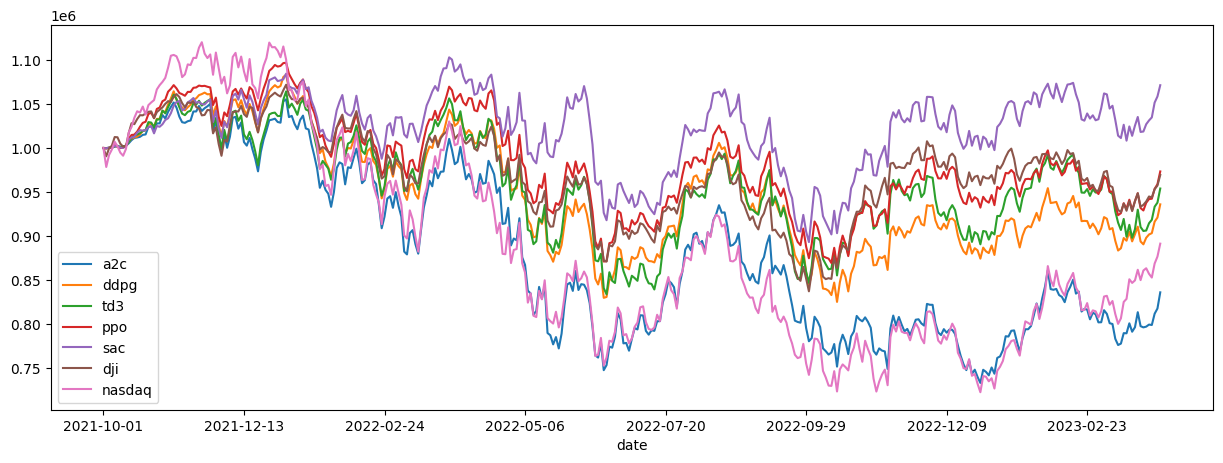

In [56]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

In [57]:
df_result_a2c.head()

,account_value
date,
2021-10-01,1.000000e+06
2021-10-04,9.998825e+05
2021-10-05,1.000200e+06
2021-10-06,1.000192e+06
2021-10-07,1.001517e+06


In [58]:
df_result_ppo.head()

,account_value
date,
2021-10-01,1.000000e+06
2021-10-04,9.995864e+05
2021-10-05,1.000201e+06
2021-10-06,1.000804e+06
2021-10-07,1.003194e+06


In [59]:
df_result_a2c.iloc[-1,0]

835685.5677356377

In [60]:
print('A2C로 얻은 투자 수익률>>', round((df_result_a2c.iloc[-1,0]/df_result_a2c.iloc[0,0]-1)*100,2),'%')
print('DDPG로 얻은 투자 수익률>>', round((df_result_ddpg.iloc[-1,0]/df_result_ddpg.iloc[0,0]-1)*100,2),'%')
print('TD3로 얻은 투자 수익률>>', round((df_result_td3.iloc[-1,0]/df_result_td3.iloc[0,0]-1)*100,2),'%')
print('PPO로 얻은 투자 수익률>>', round((df_result_ppo.iloc[-1,0]/df_result_ppo.iloc[0,0]-1)*100,2),'%')
print('SAC로 얻은 투자 수익률>>', round((df_result_sac.iloc[-1,0]/df_result_sac.iloc[0,0]-1)*100,2),'%')
print('DOW JONES로 얻은 투자 수익률>>', round((df_dji.iloc[-1,0]/df_dji.iloc[0,0]-1)*100,2),'%')

A2C로 얻은 투자 수익률>> -16.43 %
DDPG로 얻은 투자 수익률>> -6.41 %
TD3로 얻은 투자 수익률>> -4.61 %
PPO로 얻은 투자 수익률>> -2.67 %
SAC로 얻은 투자 수익률>> 7.15 %
DOW JONES로 얻은 투자 수익률>> -3.07 %


In [61]:
df_account_value_sac

,date,account_value
0,2021-10-01,1.000000e+06
1,2021-10-04,9.996902e+05
2,2021-10-05,1.000442e+06
3,2021-10-06,1.000896e+06
4,2021-10-07,1.002126e+06
...,...,...
372,2023-03-27,1.031370e+06
373,2023-03-28,1.034847e+06
374,2023-03-29,1.051739e+06
375,2023-03-30,1.058656e+06


In [70]:
df_actions_sac

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,
2021-10-01,100,100,0,100,100,0,100,0,0
2021-10-04,100,100,0,100,100,0,100,0,0
2021-10-05,100,100,0,100,100,0,100,0,0
2021-10-06,100,100,0,100,100,0,100,0,0
2021-10-07,100,100,0,100,100,0,100,0,0
...,...,...,...,...,...,...,...,...,...
2023-03-24,0,0,0,0,0,0,0,0,0
2023-03-27,0,0,0,0,0,0,0,0,0
2023-03-28,0,0,0,0,0,0,0,0,0


In [71]:
total = [0,0,0,0,0,0,0,0,0]
for index, j in enumerate(df_actions_sac.columns):
  for i in df_actions_sac[j]:
    if i>0 :
      total[index] += i

print(total)

[2200, 2200, 0, 2201, 2243, 0, 2300, 0, 0]


<Axes: xlabel='date'>

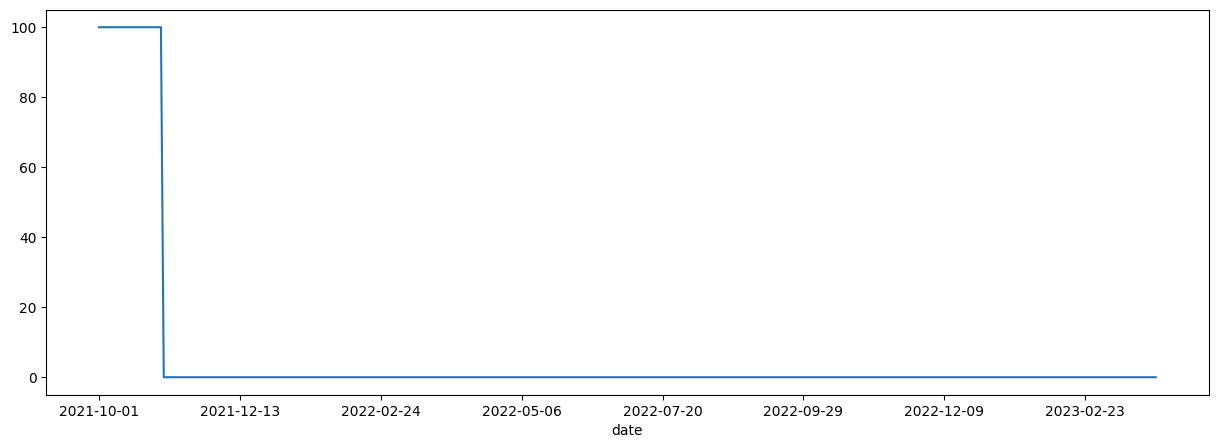

In [75]:
df_actions_sac['XLU'].plot()

<Axes: xlabel='date'>

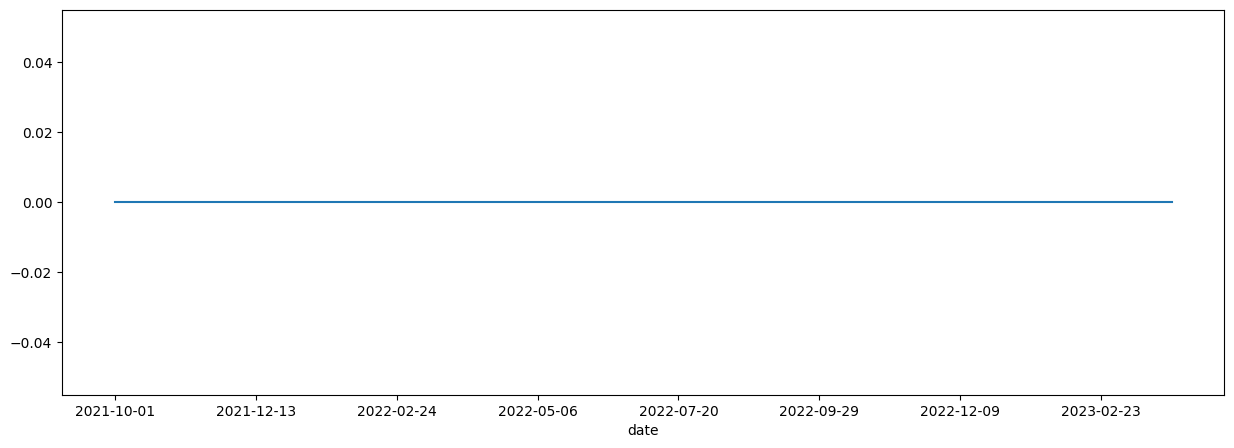

In [65]:
df_actions_ppo['XLE'].plot()

In [66]:
k = mvo_df.pivot(index='date',columns='tic',values='close').index.tolist().index('2021-10-01')
print(k)

2957


<Axes: xlabel='date'>

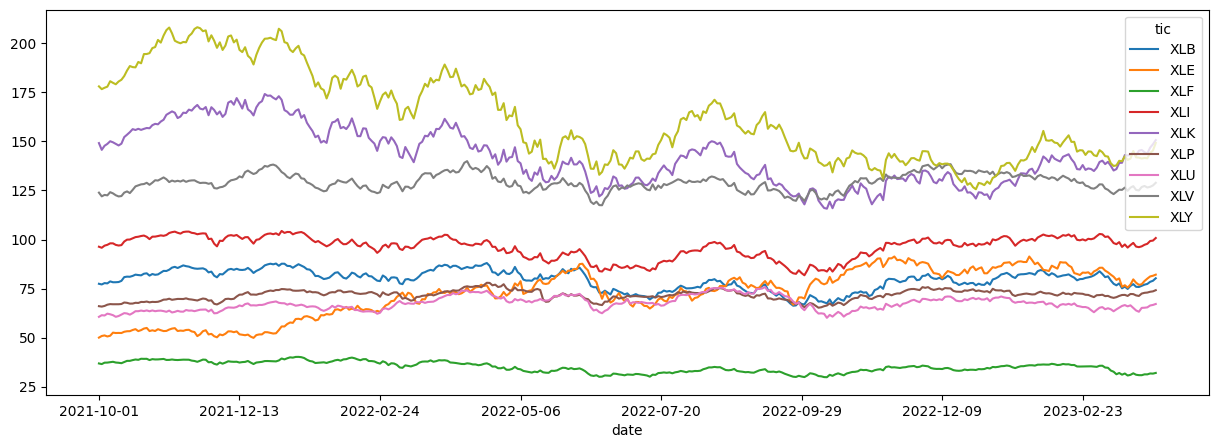

In [67]:
mvo_df.pivot(index='date',columns='tic',values='close')[k:].plot()

<Figure size 1500x500 with 0 Axes>

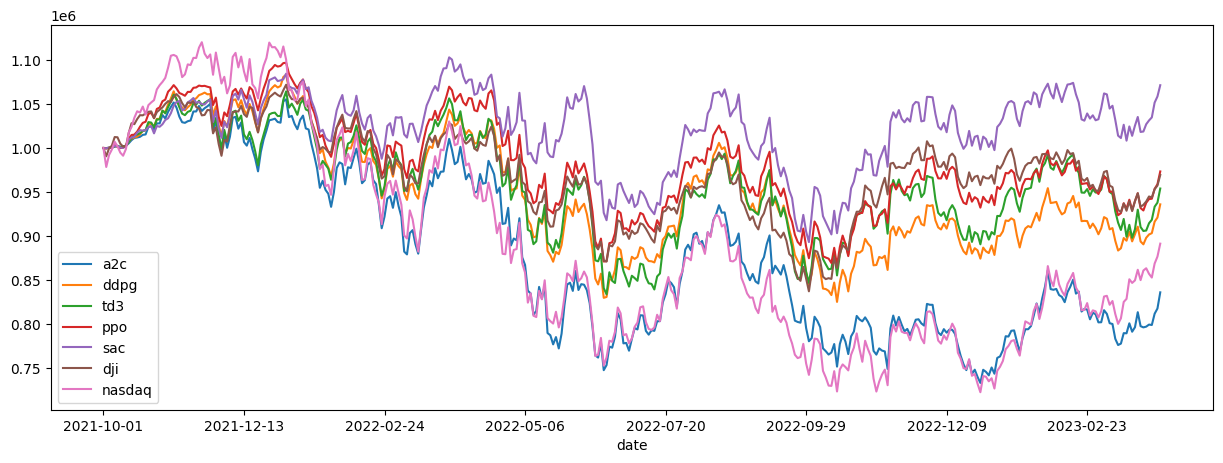

In [68]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

## Feedback

- too many "user-defined" hyper parameters : 사용자 설정 하이퍼파라미터가 너무 많음. instantiated hyper parameter들을 empirical 하게 찾는 과정 필요함 (optuna)

  - instantiated hyper paramters : 전처리

    > closed_30_sma, closed_60_sma (rolling period)

  - instantiated settings : 모델 내부 issues

    > h_max : 한번에 거래할 수 있는 maximum number of shares

    > TRAIN_START_DATE, TRAIN_END_DATE, TRADE_START_DATE, TRADE_END_DATE

    > policy : 학습 알고리즘에 따라 어떤 policy를 사용할건지

  - baseline setting : 학습 방법, Trajectory(State space, Action space, Reward)

    > train 시점 : 한번에, 여러 시간에 거쳐서 time dependent 하게

    > action space : `actions * hmax` 부분에서 `actions`가 -1과 1사이라서, `hmax`를 곱해주면 [ -hmax, hmax ] 로 action sapce의 범위가 나온다.

    > reward : maximize total balance가 아닌 다른 reward setting을 한다면?

    > MACD 전략이 아니라 `INDICATORS`를 보조지표로 "활용"하고 있음. main 전략을 바꾼다면? (short sell을 활용한 헷징, 분산투자로 risk 감소)


In [69]:
# DRLAGent() # How action space is defined
# DRL models from Stable Baselines 3
from __future__ import annotations

import time

import numpy as np
import pandas as pd
from stable_baselines3 import A2C
from stable_baselines3 import DDPG
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3 import TD3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv

from finrl import config
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.preprocessor.preprocessors import data_split

MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}

MODEL_KWARGS = {x: config.__dict__[f"{x.upper()}_PARAMS"] for x in MODELS.keys()}

NOISE = {
    "normal": NormalActionNoise,
    "ornstein_uhlenbeck": OrnsteinUhlenbeckActionNoise,
}


class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        try:
            self.logger.record(key="train/reward", value=self.locals["rewards"][0])
        except BaseException:
            self.logger.record(key="train/reward", value=self.locals["reward"][0])
        return True

class DRLAgent:
    """Provides implementations for DRL algorithms

    Attributes
    ----------
        env: gym environment class
            user-defined class

    Methods
    -------
        get_model()
            setup DRL algorithms
        train_model()
            train DRL algorithms in a train dataset
            and output the trained model
        DRL_prediction()
            make a prediction in a test dataset and get results
    """

    def __init__(self, env):
        self.env = env

    def get_model(
        self,
        model_name,
        policy="MlpPolicy",
        policy_kwargs=None,
        model_kwargs=None,
        verbose=1,
        seed=None,
        tensorboard_log=None,
    ):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")

        if model_kwargs is None:
            model_kwargs = MODEL_KWARGS[model_name]

        if "action_noise" in model_kwargs:
            n_actions = self.env.action_space.shape[-1]
            model_kwargs["action_noise"] = NOISE[model_kwargs["action_noise"]](
                mean=np.zeros(n_actions), sigma= sigma_ * np.ones(n_actions), theta=theta_ * np.ones(n_actions)
            )
        print(model_kwargs)
        return MODELS[model_name](
            policy=policy,
            env=self.env,
            tensorboard_log=tensorboard_log,
            verbose=verbose,
            policy_kwargs=policy_kwargs,
            seed=seed,
            **model_kwargs,
        )

    def train_model(self, model, tb_log_name, total_timesteps=5000):
        model = model.learn(
            total_timesteps=total_timesteps,
            tb_log_name=tb_log_name,
            callback=TensorboardCallback(),
        )
        return model

    @staticmethod
    def DRL_prediction(model, environment, deterministic=True):
        test_env, test_obs = environment.get_sb_env()
        """make a prediction"""
        account_memory = []
        actions_memory = []
        #         state_memory=[] #add memory pool to store states
        test_env.reset()
        for i in range(len(environment.df.index.unique())):
            action, _states = model.predict(test_obs, deterministic=deterministic)
            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
            test_obs, rewards, dones, info = test_env.step(action)
            if i == (len(environment.df.index.unique()) - 2):
                account_memory = test_env.env_method(method_name="save_asset_memory")
                actions_memory = test_env.env_method(method_name="save_action_memory")
            #                 state_memory=test_env.env_method(method_name="save_state_memory") # add current state to state memory
            if dones[0]:
                print("hit end!")
                break
        return account_memory[0], actions_memory[0]

    @staticmethod
    def DRL_prediction_load_from_file(model_name, environment, cwd, deterministic=True):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")
        try:
            # load agent
            model = MODELS[model_name].load(cwd)
            print("Successfully load model", cwd)
        except BaseException:
            raise ValueError("Fail to load agent!")

        # test on the testing env
        state = environment.reset()
        episode_returns = []  # the cumulative_return / initial_account
        episode_total_assets = [environment.initial_total_asset]
        done = False
        while not done:
            action = model.predict(state, deterministic=deterministic)[0]
            state, reward, done, _ = environment.step(action)

            total_asset = (
                environment.amount
                + (environment.price_ary[environment.day] * environment.stocks).sum()
            )
            episode_total_assets.append(total_asset)
            episode_return = total_asset / environment.initial_total_asset
            episode_returns.append(episode_return)

        print("episode_return", episode_return)
        print("Test Finished!")
        return episode_total_assets
